# library import

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [11]:
import re
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier

import gdown

#import warnings
#warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# data load

In [3]:
!git clone https://github.com/jeongminia/Cancer-Classification.git
!unzip -qq '/content/Cancer-Classification/data/open.zip'
!unzip -qq '/content/Cancer-Classification/data/preprocessed_data.zip'

Cloning into 'Cancer-Classification'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 184 (delta 80), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (184/184), 12.82 MiB | 7.34 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [ ]:
# 공유 링크에서 ID 추출
url = f"https://drive.google.com/uc?id=1TP-l24eJn_oZVlOG8KLQHkK4W0wRUqKV"

# 파일 다운로드
output = 'preprocessed_trainv2.csv'
gdown.download(url, output, quiet=False)

# 데이터프레임으로 읽기
train = pd.read_csv(output)

# 공유 링크에서 ID 추출
url = f"https://drive.google.com/uc?id=1-RkNKFSRLFVG0LawcfEMTv1t-zIhoOZJ"

# 파일 다운로드
output = 'preprocessed_trainv2.csv'
gdown.download(url, output, quiet=False)

# 데이터프레임으로 읽기
test = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1TP-l24eJn_oZVlOG8KLQHkK4W0wRUqKV
To: /content/preprocessed_trainv2.csv
100%|██████████| 54.3M/54.3M [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-RkNKFSRLFVG0LawcfEMTv1t-zIhoOZJ
To: /content/preprocessed_trainv2.csv
100%|██████████| 22.3M/22.3M [00:00<00:00, 128MB/s] 


In [4]:
train = pd.read_csv('/content/preprocessed_train.csv')
test = pd.read_csv('/content/preprocessed_test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [5]:
print(train)
print(test)

      Unnamed: 0          ID  SUBCLASS  A2M  AAAS  AADAT  AARS1  ABAT  ABCA1  \
0              0  TRAIN_0000         8    1     1      1      1     1      1   
1              1  TRAIN_0001        19    1     1      1      1     1      1   
2              2  TRAIN_0002        20    1     1      1      1     1      1   
3              3  TRAIN_0003         9    1     1      1      1     1      1   
4              4  TRAIN_0004         6    1     1      1      1     1      1   
...          ...         ...       ...  ...   ...    ...    ...   ...    ...   
6196        6196  TRAIN_6196        13    1     1      1      1     1      1   
6197        6197  TRAIN_6197        11    1     1      1      1     1      1   
6198        6198  TRAIN_6198         4    1     1      1      1     1      1   
6199        6199  TRAIN_6199        22    1     1      1      1     1      1   
6200        6200  TRAIN_6200        20    1     1      1      1     1      1   

      ABCA2  ...  ZNF365  ZNF639  ZNF70

# data split


In [14]:
X = train.drop(columns=['Unnamed: 0', 'SUBCLASS', 'ID'])
y = train['SUBCLASS']

In [15]:
X

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,18
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,12
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,85
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,4
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,33
6197,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,8
6198,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,10,1,13
6199,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5


In [16]:
y

,SUBCLASS
0,8
1,19
2,20
3,9
4,6
...,...
6196,13
6197,11
6198,4
6199,22


In [17]:
# 범주형 변수를 찾기
cat_features_indices = X.select_dtypes(include=['object']).columns

# 범주형 변수의 인덱스 찾기
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features_indices]

print("범주형 변수 인덱스:", cat_feature_indices)

범주형 변수 인덱스: []


In [18]:
# 데이터 분할 (각 클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 각 클래스 비율 유지
)

# model train

In [20]:
#lightGBM, ExtraTreesClassifier, RandomForestClassifier 선택
model = lgbm.LGBMClassifier()

et_cls = ExtraTreesClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=12)
rf_cls = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=12)
lg_cls = model.fit(X_train,y_train)

# 모델 voting
voting = VotingClassifier(
    estimators=[
        ('et', et_cls),
        ('rf', rf_cls),
        ('lg', lg_cls)
    ]
)
voting.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13203
[LightGBM] [Info] Number of data points in the train set: 4960, number of used features: 2434
[LightGBM] [Info] Start training from score -4.448718
[LightGBM] [Info] Start training from score -4.090320
[LightGBM] [Info] Start training from score -2.065030
[LightGBM] [Info] Start training from score -3.688879
[LightGBM] [Info] Start training from score -3.327377
[LightGBM] [Info] Start training from score -5.075174
[LightGBM] [Info] Start training from score -2.598364
[LightGBM] [Info] Start training from score -3.327377
[LightGBM] [Info] Start training from score -2.488138
[LightGBM] [Info] Start training from score -2.921912
[LightGBM] [Info] Start training from score -3.672879
[LightGBM] [Info] Start training from score -3.2996

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(max_features=12,
                                                   min_samples_leaf=5,
                                                   min_samples_split=7,
                                                   n_estimators=500)),
                             ('rf',
                              RandomForestClassifier(max_features=12,
                                                     min_samples_leaf=5,
                                                     min_samples_split=7,
                                                     n_estimators=500)),
                             ('lg', LGBMClassifier())])

# model evaluation

In [28]:
y_pred = voting.predict(X_val)
print(y_pred)

[2 2 2 ... 6 2 2]


<Figure size 1200x800 with 0 Axes>

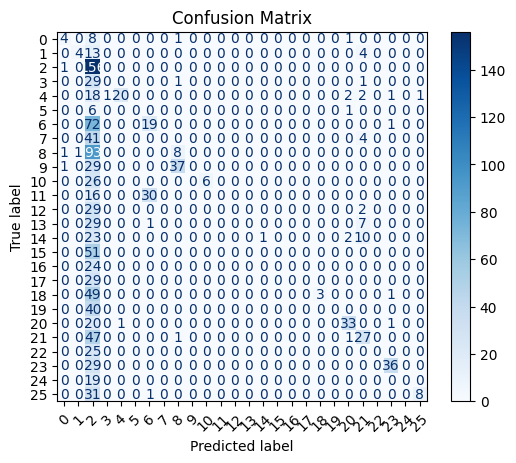

In [29]:
# confusion matrix 계산
cm = confusion_matrix(y_val, y_pred)

# confusion matrix 시각화
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

# predict SUBCLASS

In [23]:
X_test = test.drop(columns=['ID'])
print(X_test)

      A2M  AAAS  AADAT  AARS1  ABAT  ABCA1  ABCA2  ABCA3  ABCA4   ABCA5  ...  \
0       1     1      1      1     1      1      1      1      1       1  ...   
1       1     1      1      1     1     10      1      1      1       1  ...   
2       1     1      1      1     1      1      1      1      1       1  ...   
3       1     1      1      1     1      1      1      1      1       1  ...   
4       1     1      1      1     1      1      1      1      1       1  ...   
...   ...   ...    ...    ...   ...    ...    ...    ...    ...     ...  ...   
2541    1     1      1      1     1      1      1      1      1       1  ...   
2542    1     1      1      1     1      1      1      1      1       1  ...   
2543    1     1      1      1     1     10      1     10     10  100000  ...   
2544    1     1      1      1     1      1      1      1     10       1  ...   
2545    1     1      1      1     1      1      1      1      1       1  ...   

      ZNF365  ZNF639  ZNF707  ZNFX1   Z

In [33]:
predictions = voting.predict(X_test)
print(predictions)

[21 21  2 ... 21 10  6]


In [34]:
# 레이블 변환을 위한 맵 딕셔너리
label_map = {
    0: "ACC",
    1: "BLCA",
    2: "BRCA",
    3: "CESC",
    4: "COAD",
    5: "DLBC",
    6: "GBMLGG",
    7: "HNSC",
    8: "KIPAN",
    9: "KIRC",
    10: "LAML",
    11: "LGG",
    12: "LIHC",
    13: "LUAD",
    14: "LUSC",
    15: "OV",
    16: "PAAD",
    17: "PCPG",
    18: "PRAD",
    19: "SARC",
    20: "SKCM",
    21: "STES",
    22: "TGCT",
    23: "THCA",
    24: "THYM",
    25: "UCEC"
}

# y_pred 값 변환
predictions_transformed = [label_map[pred] for pred in predictions]

# 변환된 y_pred 출력
print(predictions_transformed)

['STES', 'STES', 'BRCA', 'BRCA', 'STES', 'SARC', 'BRCA', 'SKCM', 'BRCA', 'BRCA', 'BRCA', 'LAML', 'BRCA', 'STES', 'BRCA', 'STES', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'COAD', 'COAD', 'GBMLGG', 'BRCA', 'BRCA', 'COAD', 'BRCA', 'STES', 'BRCA', 'BRCA', 'COAD', 'SKCM', 'COAD', 'BRCA', 'BRCA', 'COAD', 'BRCA', 'BRCA', 'BLCA', 'BRCA', 'BRCA', 'BRCA', 'SKCM', 'SKCM', 'BRCA', 'BRCA', 'KIPAN', 'BRCA', 'BRCA', 'BRCA', 'COAD', 'KIPAN', 'COAD', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'STES', 'BRCA', 'BRCA', 'STES', 'COAD', 'BRCA', 'STES', 'COAD', 'SKCM', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'STES', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'UCEC', 'COAD', 'BRCA', 'STES', 'STES', 'BRCA', 'STES', 'BRCA', 'THCA', 'KIPAN', 'BRCA', 'BRCA', 'BRCA', 'KIPAN', 'BRCA', 'KIRC', 'COAD', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'STES', 'STES', 'BRCA', 'THCA', 'BRCA', 'BRCA', 'COAD', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'STES', 'STES', 'BRCA', 'BRCA', 'BRCA', '

In [35]:
print("predictions의 길이:", len(predictions_transformed))
print("submisson의 길이:", len(submission))

predictions의 길이: 2546
submisson의 길이: 2546


In [38]:
#predictions_transformed = predictions_transformed.ravel()  # 또는 predictions.flatten()
submission["SUBCLASS"] = predictions_transformed

In [39]:
submission.to_csv('submission.csv', encoding='UTF-8-sig', index=False)